# Développement d'un Système de recommandation de livres

Ce système de recommandation a pour but de prédire la note ou la préférence qu'un utilisateur attibuerait à un livre (Ouvrage) en considérant ses anciennes notes ou préferences des différents ouvrages. Ce type de système de recommandation est beaucoup plus utilisé par certaines compagnies dans le but d'améliorer considérablement la qualité de leur services mais aussi le chiffre d'affaire.

Dans le cadre de ce travail, nous utilisons 2 bases de données (Fichiers CSV, contenant respectivement les informations suivantes :

1. ratings.csv (taille 68,7 MO) dont la structure est :  
user_id,book_id,rating

2. books.csv ( taille 3,13 MO) dont la structure est :
book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,
title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,
ratings_4,ratings_5,image_url,small_image_url

La travail est développé sous trois principaux points :

1. Chargement et analyse des données pertinentes pour l'étude
2. Développement de modèles
3. Recommandations

In [364]:
# Nous importons d'abord les principales librairies que nous allons utiliser

import numpy as np   # pour la gestion des données sous format matricielle
import pandas as pd  # pour la gestion des data frames
import matplotlib.pyplot as plt  # pour la visualisation dynamique

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense # pour le développement de modèles CNN
from tensorflow.keras.models import Model

import os # pour les fichiers système
import warnings

warnings.filterwarnings('ignore') 
%matplotlib inline

 ## 1. Chargement et analyse des deux bases de données

### 1.1 Analyse de la base de données  des notes "ratings"

In [365]:
#Chargement de  la base de données des notes

ratings = pd.read_csv('data/ratings.csv')

In [366]:
ratings.head(10)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5


In [367]:
# dimension de la base de données
ratings.shape

(5976479, 3)

In [368]:
# Vérification si un utilisateur a noté un même livre plus d'une fois, dans ce cas, nous prendrons la note maximum

ratings_df = ratings.groupby(['user_id','book_id']).aggregate(np.max)

In [369]:
# Dans le cas présent, la longeur de ratings_df est égale à la longeur de ratings, donc, chaque livre a été noté une seul fois
# par un utilisateur

len(ratings_df)

5976479

In [370]:
# Inspection des données
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [371]:
ratings_df.head(20)

rating
user_id book_id        
1       4             5
        10            4
        11            5
        13            4
        16            3
        22            3
        31            4
        32            4
        33            4
        35            5
        36            4
        38            2
        40            2
        42            3
        43            4
        45            5
        46            4
        47            3
        54            3
        57            3

In [372]:
# Nombre total d'utilisateurs

n_users = len(ratings['user_id'].unique())
n_users

53424

In [373]:
# Nombre total de livres

n_books = len(ratings['book_id'].unique())
n_books

10000

In [374]:
#Analyse du pourcentage pour chaque note

count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['user_id']*100/count_ratings['user_id'].sum(),1)

In [375]:
count_ratings

,user_id,book_id,perc_total
rating,,,
1,124195,124195,2.1
2,359257,359257,6.0
3,1370916,1370916,22.9
4,2139018,2139018,35.8
5,1983093,1983093,33.2


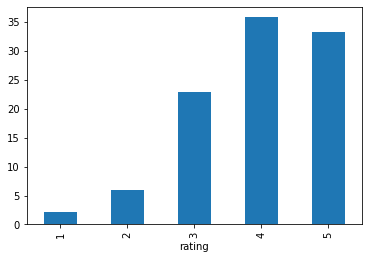

In [376]:
#Visualisation du pourcentage total pour chaque note

count_ratings['perc_total'].plot.bar()

68 % des livres sont notés au dessus de 4/5

In [378]:
# les dix premiers livres les mieux notés par l'utilisateur 2

ratings_2 = ratings.loc[ratings['user_id'] ==2].sort_values(by=['rating','book_id'], ascending=False).head(10)
ratings_2

,user_id,book_id,rating
3,2,9296,5
5694972,2,8855,5
11,2,8519,5
5694989,2,8014,5
5694984,2,7402,5
5695004,2,7233,5
5694988,2,6384,5
10,2,3753,5
9,2,2686,5
5695019,2,2166,5


In [381]:
# Les cinq utilisateurs ayant bien notés le livre dont l'ID est 9296

ratings_bookID9296 = ratings.loc[ratings['book_id'] == 9296].sort_values(by=['rating'], ascending=False).head(5)
ratings_bookID9296

,user_id,book_id,rating
3,2,9296,5
4003526,4170,9296,5
1311776,19182,9296,5
1322303,19245,9296,5
3867418,44428,9296,5


In [385]:
# Les 5 autres livres mieux notés par l'utilisateur dont l'ID est 4170

ratings_4170 = ratings.loc[ratings['user_id'] ==4170].sort_values(by=['rating','book_id'], ascending=False).head(10)
ratings_4170


,user_id,book_id,rating
3169459,4170,9688,5
4003526,4170,9296,5
3169457,4170,8296,5
4003534,4170,7770,5
4003519,4170,7382,5
4003535,4170,6988,5
3169458,4170,5387,5
4003527,4170,5050,5
4003537,4170,4735,5
4003522,4170,3419,5


L'utilisateur 2 et l'utilisateur 4170 ont tous rès bien noté le livre 9296. Cette liste de livres bien notés par l'utilisateur 4170 pourrait aussi ntéresser l'utilisateur 2.

Les modèles de  recommandattion que l'on va développer au niveau des sections qui suivent s'appuient sur cette logique

### 1.2 Analyse de la base de données  des livres/ouvrages  "books"

In [386]:
#chargement du fichier de données

books_list = pd.read_csv('data/books.csv')

In [387]:
len(books_list)

10000

In [388]:
#inspection du data frame de livres

books_list.head(10)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...


In [391]:
# Le nombre de livres uniques au niveau du dataset.

len(books_list['book_id'].unique())

10000

In [395]:
# Extraction des composantes average_rating , ratings_count et authors pour quelques analyses

avg_BookRating = books_list[['book_id', 'average_rating','ratings_count','authors']]

# Les dix livres les mieux notés
avg_BookRating.sort_values(by=['average_rating'], ascending=False).head(10)

,book_id,average_rating,ratings_count,authors
3627,3628,4.82,28900,Bill Watterson
3274,3275,4.77,33220,"J.K. Rowling, Mary GrandPré"
861,862,4.77,73572,Brandon Sanderson
8853,8854,4.76,9081,Francine Rivers
7946,7947,4.76,8953,"Anonymous, Lane T. Dennis, Wayne A. Grudem"
4482,4483,4.75,22351,Bill Watterson
6360,6361,4.74,16766,Bill Watterson
421,422,4.74,190050,J.K. Rowling
3752,3753,4.73,24618,J.K. Rowling
6919,6920,4.73,14597,Bill Watterson


In [396]:
# Les dix livres les moins bien notés et leurs auteurs

avg_BookRating.sort_values(by=['average_rating'], ascending=True).head(10)

,book_id,average_rating,ratings_count,authors
1792,1793,2.47,40718,Chetan Bhagat
3549,3550,2.67,28299,Alice Sebold
8006,8007,2.76,9627,Howard Jacobson
9020,9021,2.80,12534,"Gregory Maguire, Douglas Smith"
4008,4009,2.80,22278,Candace Bushnell
8165,8166,2.84,8458,Julia Pierpont
8873,8874,2.84,9733,Chuck Palahniuk
4282,4283,2.84,19210,Lauren Weisberger
4613,4614,2.93,15362,Claire Messud
8959,8960,2.93,10621,Mark Haddon


In [398]:
# les trente livres qui ont été notés par un plus grand nombre de lecteurs et leus auteurs

avg_BookRating.sort_values(by=['ratings_count'], ascending=False).head(30)

,book_id,average_rating,ratings_count,authors
0,1,4.34,4780653,Suzanne Collins
1,2,4.44,4602479,"J.K. Rowling, Mary GrandPré"
2,3,3.57,3866839,Stephenie Meyer
3,4,4.25,3198671,Harper Lee
4,5,3.89,2683664,F. Scott Fitzgerald
5,6,4.26,2346404,John Green
6,7,4.25,2071616,J.R.R. Tolkien
7,8,3.79,2044241,J.D. Salinger
9,10,4.24,2035490,Jane Austen
8,9,3.85,2001311,Dan Brown


## 2. Développement de modèles pour le système de recommandation

### 2.1 Quelques analyses et préparations des données

In [403]:
#fusion des data frames books et ratings

ratings_books = pd.merge(ratings,books_list, on = 'book_id')
ratings_books.head()

,user_id,book_id,rating,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
1,11,258,3,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
2,143,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
3,242,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
4,325,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...


In [445]:
# On retient les  livres qui ont été notés 4 et plus

ratings_books = pd.merge(ratings,books_list, on = 'book_id')
ratings_books = ratings_books[ratings_books['rating'] > 4]
ratings_books.head()

,user_id,book_id,rating,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
3,242,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
10,499,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
11,579,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
13,752,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...


In [440]:
#Top 10 des livres qui ont été très bien notés par les utilisateurs qui ont bien noté ( note > 4) un livre donné

def get_other_books(book_id):
    
    #Utilisateurs qui ont noté le livre
    df_books_users_series = ratings_books.loc[ratings_books['book_id']== book_id]['user_id']
    
    #conversion en data frame
    df_books_users = pd.DataFrame(df_books_users_series,columns=['user_id'])
    
    #liste de tous les autres livre qui ont été bien noté par ces utilisateurs
    other_books = pd.merge(df_books_users,ratings_books,on='user_id')
    
    #liste des livres qui ont été les mieux notés par ces utilisateurs
    other_users_liked = pd.DataFrame(other_books.groupby('book_id')['user_id'].count()).sort_values('user_id',ascending=False)   
    
    return other_users_liked[:10]
    
 

In [442]:
# Top 10 des livres qui ont été mieux notés par les utilisateurs qui ont bien notés le livre 1232

get_other_books(1232)

,user_id
book_id,
1232,399
1226,354
1181,345
1067,345
1151,342
1267,342
996,339
1390,325
912,324


In [444]:
#Création de la matrice avec des books ID en ligne et les user ID en colonnes
#On remplace les NAN par 0

books_wide = ratings_books.pivot(index = 'book_id', columns = 'user_id', values = 'rating').fillna(0)
books_wide.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,53415,53416,53417,53418,53419,53420,53421,53422,53423,53424
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0
5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Le modèle des K plus proches voisins 

In [446]:
from sklearn.neighbors import NearestNeighbors

#specification des paramètres du modèle
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')

#fit model au data set
model_knn.fit(books_wide)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [447]:
#top 10 de livres les plus proches à un livre donné

def print_similar_books(query_index) :
    #get the list of user ratings for a specific userId
    query_index_books_ratings = books_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 books and their distances from the book specified
    distances,indices = model_knn.kneighbors(query_index_books_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar books for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random book that was chosen
        get_book = books_list.loc[books_list['book_id']==query_index]['title']
        #for the first book in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_book))
        else :
            #get the indiciees for the closest books
            indices_flat = indices.flatten()[i]
            #get the title of the book
            get_book = books_list.loc[books_list['book_id']==books_wide.iloc[indices_flat,:].name]['title']
            #print the book
            print('{0}: {1}, with distance of {2}:'.format(i,get_book,distances.flatten()[i]))

In [448]:
print_similar_books(1232)

Recommendations for 1231    Hard Eight (Stephanie Plum, #8)
Name: title, dtype: object:

1: 1266    To the Nines (Stephanie Plum, #9)
Name: title, dtype: object, with distance of 0.10011839768517716:
2: 1225    Seven Up (Stephanie Plum, #7)
Name: title, dtype: object, with distance of 0.11166805859780171:
3: 1180    High Five (Stephanie Plum, #5)
Name: title, dtype: object, with distance of 0.13857073719448754:
4: 1150    Hot Six (Stephanie Plum, #6)
Name: title, dtype: object, with distance of 0.1396165155817154:
5: 1389    Eleven on Top (Stephanie Plum, #11)
Name: title, dtype: object, with distance of 0.1412837352570373:
6: 1066    Four to Score (Stephanie Plum, #4)
Name: title, dtype: object, with distance of 0.16121680860784016:
7: 995    Three to Get Deadly (Stephanie Plum, #3)
Name: title, dtype: object, with distance of 0.18252474527332851:
8: 1605    Ten Big Ones (Stephanie Plum, #10)
Name: title, dtype: object, with distance of 0.1854920110628402:
9: 1626    Twelve Sharp (Ste

In [449]:
print_similar_books(1)

Recommendations for 0    The Hunger Games (The Hunger Games, #1)
Name: title, dtype: object:

1: 16    Catching Fire (The Hunger Games, #2)
Name: title, dtype: object, with distance of 0.4199700493283224:
2: 19    Mockingjay (The Hunger Games, #3)
Name: title, dtype: object, with distance of 0.5150431324905729:
3: 1    Harry Potter and the Sorcerer's Stone (Harry P...
Name: title, dtype: object, with distance of 0.5684364433283482:
4: 11    Divergent (Divergent, #1)
Name: title, dtype: object, with distance of 0.6155895015117284:
5: 24    Harry Potter and the Deathly Hallows (Harry Po...
Name: title, dtype: object, with distance of 0.6686670490805615:
6: 30    The Help
Name: title, dtype: object, with distance of 0.675850821526552:
7: 2    Twilight (Twilight, #1)
Name: title, dtype: object, with distance of 0.6769374739681291:
8: 26    Harry Potter and the Half-Blood Prince (Harry ...
Name: title, dtype: object, with distance of 0.6815749886398936:
9: 20    Harry Potter and the Order o

### 2.3 Creation du modèle de réseau de neuronnes

Le choix de réseau de neuronnes est motivé par le fait que c'est un modèle très performant pour les problèmes de machine learning et il est mieux adapté dans le  cadre de développement de systèmes de recommandation.

In [452]:
from sklearn.model_selection import train_test_split

#Constitution de la base de données d'entrainement (80%) et de la base de données test(20%)
# sur base de la base de données ratings

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [453]:
train.head(10)

,user_id,book_id,rating
1701724,10714,7164,3
5361971,48091,2213,3
3243372,9809,5769,4
1808828,25191,86,5
5142988,25441,4884,3
2221808,29639,20,2
2116592,28648,2007,5
5389438,53402,1122,4
3680082,42999,45,5
3849434,44240,373,3


In [457]:
from tensorflow.keras.layers import Concatenate

# creation du path pour le book embedding
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creation du path pour le user embedding 
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenation des  features
conc_features = Concatenate()([book_vec, user_vec])

# ajout des fully-connected-layers
fc1 = Dense(128, activation='relu')(conc_features)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Creation et compilation du modèle
model = Model([user_input, book_input], out)
model.compile('adam', 'mean_squared_error')

Train on 4781183 samples
Epoch 1/5
4781183/4781183 [==============================] - 659s 138us/sample - loss: 0.7750
Epoch 2/5
4781183/4781183 [==============================] - 654s 137us/sample - loss: 0.7241
Epoch 3/5
4781183/4781183 [==============================] - 662s 138us/sample - loss: 0.7025
Epoch 4/5
4781183/4781183 [==============================] - 687s 144us/sample - loss: 0.6839
Epoch 5/5
4781183/4781183 [==============================] - ETA: 0s - loss: 0.670 - 701s 147us/sample - loss: 0.6703


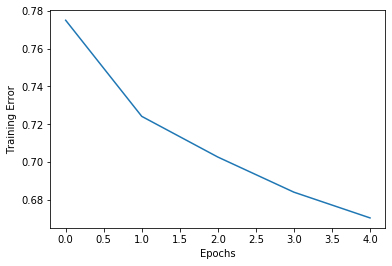

In [458]:
from tensorflow.keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [459]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
___________________________________________________________________________________________

In [460]:
model.evaluate([test.user_id, test.book_id], test.rating)

1195296/1195296 [==============================] - 54s 45us/sample - loss: 0.6942


0.6941743690768958

In [461]:
# Prédictions

predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.2662768] 3
[3.0154362] 4
[4.5682764] 5
[2.6712499] 2
[3.5351572] 4
[3.8800917] 4
[4.17922] 4
[4.0449686] 4
[4.3782334] 5
[3.4799938] 4


[None, None, None, None, None, None, None, None, None, None]


#### -> Visualisation des Embeddings

Les embeddings sont les poids qui sont apprises pour representer certaines variables spécifiques. Dans le cas de cette étude ce sont les livres(ouvrages) et les utilisateurs(users). On  les utilise de ce fait pour avoir de meilleurs résultats dans la résolution du problème.

In [462]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [463]:
#Synthèse des embeddings pour les livres

pd.DataFrame(book_em_weights).describe()

,0,1,2,3,4
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,-0.266828,0.493591,0.142228,-0.285983,1.158959
std,0.721313,0.728527,0.643822,0.656916,0.833832
min,-2.677192,-1.973284,-2.392973,-2.075596,-2.052323
25%,-0.767830,-0.028359,-0.231621,-0.775937,0.591752
50%,-0.199255,0.532854,0.186596,-0.333005,1.148956
75%,0.278800,1.017832,0.558120,0.150485,1.684954
max,1.800362,2.550786,2.972930,2.649843,4.759179


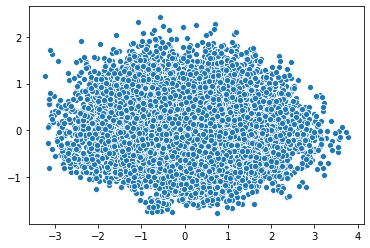

In [464]:
# Via le PCA

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [465]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

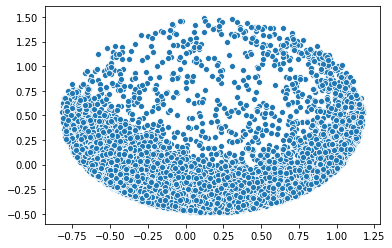

In [476]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [467]:
#Avec TSNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.007s...
[t-SNE] Computed neighbors for 10001 samples in 0.722s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.099562
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.983536
[t-SNE] KL

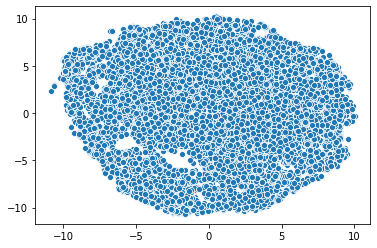

In [468]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

### 2.3 Recommandations

Dans le cadre de recommandations, nous analysons la recommandation de livres pour l'utilisateur 2 à l'aide du modèle
développé avec les réseau de neuronnes

In [469]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(ratings.book_id)))
book_data[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [470]:
user = np.array([ 2 for i in range(len(book_data))])
user[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [472]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([4482, 6360, 5206, 6589, 1787], dtype=int64)

In [473]:
# Predicted scores
predictions[recommended_book_ids]

array([5.3379316, 5.3140335, 5.2822533, 5.270702 , 5.265524 ],
      dtype=float32)

In [475]:
# La liste des 5 premiers livres à recommander à l'utilisateur dont l'id est 2

books_list[books_list['book_id'].isin(recommended_book_ids)]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1786,1787,20317106,20317106,28155746,7,NaN,NaN,محمد صادق,2014.0,هيبتا,...,42978,43298,5680,2886,4135,8052,11237,16988,https://images.gr-assets.com/books/1403045796m...,https://images.gr-assets.com/books/1403045796s...
4481,4482,73297,73297,281071,27,842342710,9.780842e+12,Francine Rivers,1995.0,The Scarlet Thread,...,21233,22189,715,235,821,4007,7627,9499,https://images.gr-assets.com/books/1406510347m...,https://images.gr-assets.com/books/1406510347s...
5205,5206,13066,13066,2257006,31,446695688,9.780447e+12,Carl Hiaasen,2000.0,Sick Puppy,...,18248,19594,1069,193,861,5077,8434,5029,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6359,6360,675905,675905,661908,10,312997191,9.780313e+12,Elin Hilderbrand,2003.0,Summer People,...,14369,15792,623,126,649,4124,6239,4654,https://images.gr-assets.com/books/1317063942m...,https://images.gr-assets.com/books/1317063942s...
6588,6589,41710,41710,3132229,66,425197387,9.780425e+12,Clive Cussler,1974.0,Iceberg,...,16195,17357,366,141,863,5131,6881,4341,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
